# California Housing Price Prediction

In [130]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion


In [85]:
pd.options.display.max_columns = None
%matplotlib inline

In [86]:
#Reading the data

housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [87]:
#Checking the features in the dataset

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The dataset has 20640 samples, 9 independent features and 1 dependent feature. There are some missing values in "total_bedrooms". The aim is predict "median_house_value".

In [88]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [89]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

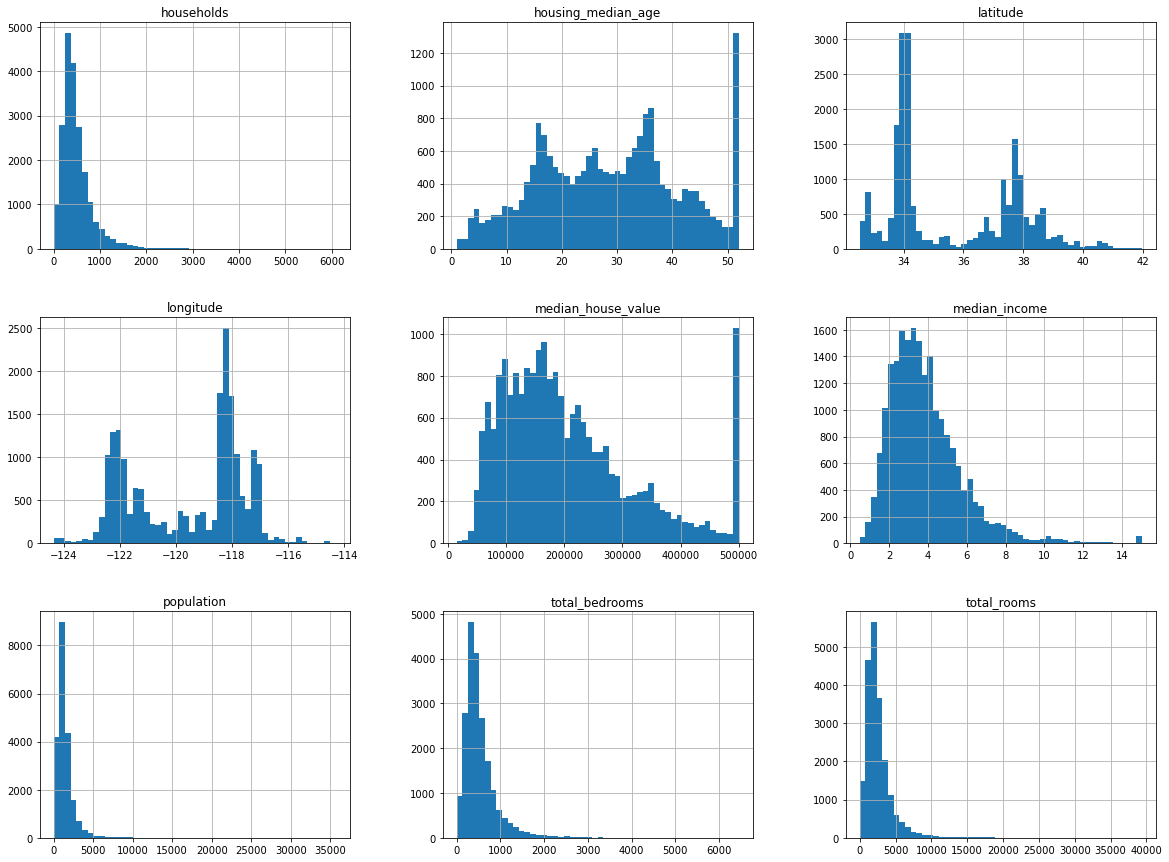

In [90]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Analyzing the distribution of the continuous features of the dataset.

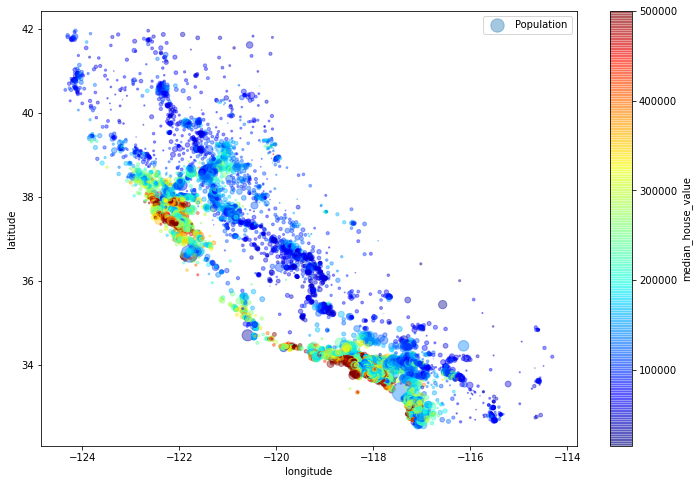

In [91]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha=0.4, 
            s = housing['population']/100, label = "Population", figsize=(12,8),
            c = "median_house_value", cmap = plt.get_cmap("jet"), sharex=False)

plt.legend()

The plot of longitude vs latitude to show the population and median house value

In [92]:
#Analyzing the correlation of the dependent variable with independent variables

correlation_matrix = housing.corr()
correlation_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

The features: median_income seems to be most important feature and total_rooms, housing_median_age, households, total_bedrooms show positive correlation.

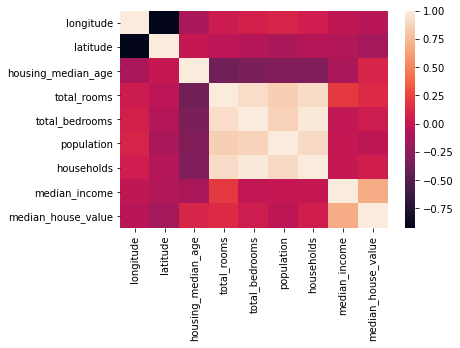

In [93]:
sns.heatmap(correlation_matrix)

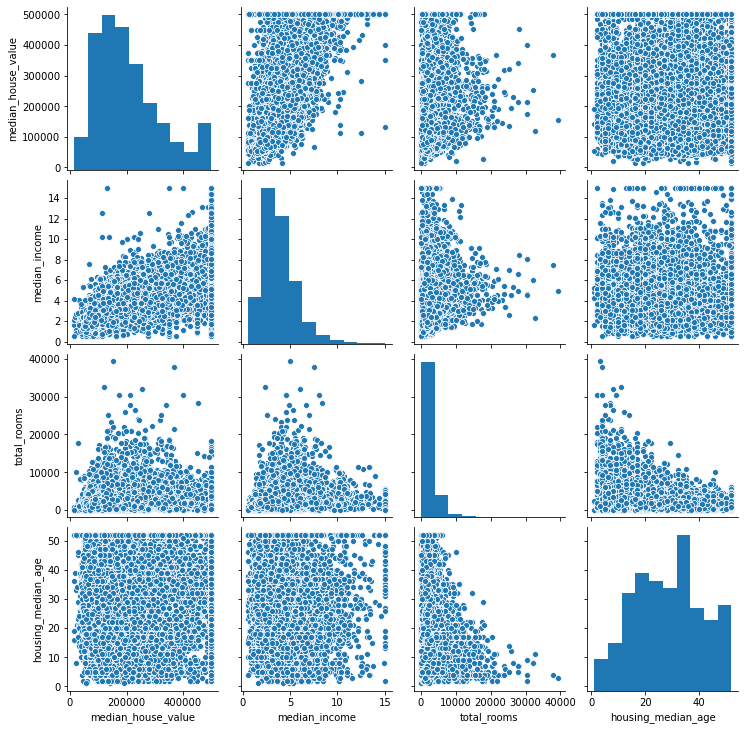

In [94]:
sns.pairplot(housing[["median_house_value", "median_income", "total_rooms", "housing_median_age"]])

In [95]:
#Handling the missing values

median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
housing[housing.isnull().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity


In [96]:
#Creating a copy after handling missing values

housing_for_pipeline = housing.copy()

In [97]:
# Dropping latitude and longitude features based on correlation

housing.drop("latitude", axis = 1, inplace = True)
housing.drop("longitude", axis = 1, inplace = True)
housing.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [98]:
#Handling the catgorical feature

le = LabelEncoder()
ohe = OneHotEncoder()

housing["ocean_proximity_labels"] = le.fit_transform(housing["ocean_proximity"])

In [100]:
housing_cat = pd.DataFrame(ohe.fit_transform(housing[["ocean_proximity_labels"]]).toarray(), \
                           columns = ["ocean_1H_OCEAN", "ocean_INLAND", "ocean_NEAR_OCEAN", "ocean_NEAR_BAY", "ocean_ISLAND"])

In [101]:
housing = pd.concat([housing, housing_cat], axis = 1, sort = False)

In [102]:
housing.drop(["ocean_proximity", "ocean_proximity_labels" ], axis = 1, inplace = True)

In [103]:
# Feature Engineering

housing["ratio_of_bedrooms"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["household_per_population"] = housing["households"] / housing["population"]
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]

In [104]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688075
household_per_population    0.264910
ocean_1H_OCEAN              0.256617
ocean_NEAR_BAY              0.160284
rooms_per_household         0.151948
ocean_ISLAND                0.141862
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049457
ocean_NEAR_OCEAN            0.023416
population                 -0.024650
ratio_of_bedrooms          -0.233303
ocean_INLAND               -0.484859
Name: median_house_value, dtype: float64

In [107]:
housing_imp_features = housing[['median_income', 'ratio_of_bedrooms', 'household_per_population', 'ocean_1H_OCEAN', \
       'ocean_INLAND', 'ocean_NEAR_OCEAN', 'ocean_NEAR_BAY', 'ocean_ISLAND']]

In [108]:
housing_imp_features.head()

,median_income,ratio_of_bedrooms,household_per_population,ocean_1H_OCEAN,ocean_INLAND,ocean_NEAR_OCEAN,ocean_NEAR_BAY,ocean_ISLAND
0,8.3252,0.146591,0.391304,0.0,0.0,0.0,1.0,0.0
1,8.3014,0.155797,0.473969,0.0,0.0,0.0,1.0,0.0
2,7.2574,0.129516,0.356855,0.0,0.0,0.0,1.0,0.0
3,5.6431,0.184458,0.392473,0.0,0.0,0.0,1.0,0.0
4,3.8462,0.172096,0.458407,0.0,0.0,0.0,1.0,0.0


## Pipeline for Preprocessing

In [109]:
housing_for_pipeline.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [111]:
housing_for_pipeline.drop(["longitude", "latitude"], axis=1, inplace=True)

In [136]:
rooms_ix, bedrooms_ix, population_ix, household_ix, income_ix = 1, 2, 3, 4, 5

class FeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y=None):
        ratio_of_bedrooms = X[:, bedrooms_ix] / X[:, rooms_ix] 
        household_per_population = X[:, household_ix] / X[:, population_ix]
        
        
        return np.c_[X[:, income_ix] , ratio_of_bedrooms, household_per_population]

In [120]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attibute_names = attribute_names
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.attibute_names].values

In [137]:
num_attribs = list(housing_for_pipeline.columns[:-2])
cat_attribs = ["ocean_proximity"]

In [138]:
# complete Pipeline

num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribs)),
    ("imputer", SimpleImputer(strategy = "median")),
    ("attribs_adder", FeatureExtraction()),
    ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attribs)),
    ("cat_encoder", OneHotEncoder(sparse = False))
])

In [139]:
full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [140]:
housing_prepared = full_pipeline.fit_transform(housing_for_pipeline)

In [141]:
median_house_price = housing_for_pipeline["median_house_value"].values

In [155]:
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [143]:
X_train, X_test, y_train, y_test = train_test_split(housing_prepared, median_house_price, test_size = 0.2, random_state = 9)

In [145]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [149]:
print(r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

0.6412071038310891 4819599270.6487255 69423.33376213451


In [153]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
y_pred = dt_reg.predict(X_test)

In [154]:
print(r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

0.39932671724936175 8068734209.498547 89826.13322134348


In [156]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

In [157]:
print(r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

0.676376859320686 4347170385.583072 65933.07505025889


In [160]:
from sklearn.svm import SVR

sv_reg = SVR()
sv_reg.fit(X_train, y_train)
y_pred = sv_reg.predict(X_test)

In [161]:
print(r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

-0.04504490501438263 14037896836.261026 118481.6307967654


In [169]:
from sklearn.ensemble import AdaBoostRegressor

ab_reg = AdaBoostRegressor(loss = "exponential")
ab_reg.fit(X_train, y_train)
y_pred = ab_reg.predict(X_test)

In [170]:
print(r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

0.11588526243439279 11876151367.096684 108977.7562950196


In [191]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(max_depth = 7, max_features = 4, n_estimators = 35)
gb_reg.fit(X_train, y_train)
y_pred = gb_reg.predict(X_test)

In [192]:
print(r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

0.6940144312565433 4110248111.631322 64111.216738035175


In [177]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

In [178]:
print(r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred)))

0.6834337573064699 4252376367.227382 65210.24740964707


In [180]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xgb_reg, housing_prepared, median_house_price, cv=10, scoring="neg_mean_squared_error")
rmse_score = np.sqrt(-scores)
rmse_score.mean()

70099.11618229633

In [182]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 20, 500], 'max_depth': [2, 4, 6, 8], 'max_features': [2, 3, 4]}
]

gb_reg_hyperparameter = GradientBoostingRegressor()
grid_search = GridSearchCV(gb_reg_hyperparameter, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, median_house_price)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid=[{'max_depth': [2, 4, 6, 8], 'max_features': [2, 3, 4],
                          'n_estimators': [10, 20, 500]}],
             scoring='neg_mean_squared_error')

In [183]:
grid_search.best_params_

{'max_depth': 2, 'max_features': 4, 'n_estimators': 500}

In [185]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_distibs = {
    'n_estimators': randint(low = 1, high = 200),
    'max_features': randint(low = 1, high = 8),
    'max_depth': randint(low = 2, high = 10)
}

gb_reg_h = GradientBoostingRegressor()
rnd_search = RandomizedSearchCV(gb_reg_h, param_distributions=params_distibs, n_iter=10, 
                                cv=5, scoring="neg_mean_squared_error", random_state=29)

rnd_search.fit(housing_prepared, median_house_price)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A2A1021388>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A2A1021248>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000A2A10FEA48>},
                   random_state=29, scoring='neg_mean_squared_error')

In [186]:
rnd_search.best_params_

{'max_depth': 7, 'max_features': 4, 'n_estimators': 35}

In [188]:
rnd_search.cv_results_

{'mean_fit_time': array([0.83468361, 0.41679993, 0.46308312, 7.54608946, 4.65104542,
        1.24008446, 8.87096953, 4.81468019, 0.07605405, 1.03658071]),
 'std_fit_time': array([0.04616252, 0.08964904, 0.01922039, 0.20920216, 0.08062164,
        0.03366681, 0.13299151, 0.06294522, 0.00701947, 0.06661364]),
 'mean_score_time': array([0.00820451, 0.00580401, 0.00600429, 0.02621813, 0.02261562,
        0.00560379, 0.03307877, 0.04042892, 0.00100141, 0.00540342]),
 'std_score_time': array([9.79024275e-04, 1.16756286e-03, 9.53674316e-08, 7.48659765e-04,
        1.20069982e-03, 4.90368725e-04, 6.42624446e-04, 1.20089851e-03,
        5.51978917e-07, 4.90154820e-04]),
 'param_max_depth': masked_array(data=[7, 2, 3, 8, 7, 2, 9, 9, 2, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=[4, 1, 1, 7, 5, 5, 7, 3, 3, 4],
              mask=[Fals

In [193]:
import pickle

file = open('chpp.pkl', 'wb')
pickle.dump(gb_reg, file)